In [1]:
#import dependencies
import os
import pandas as pd
from subprocess import call
import matplotlib.pyplot as plt

/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_4080/1106430755.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_repeats['dpiq_begin']=downstream_repeats['piq_begin']-downstream_repeats['numt_lengths']


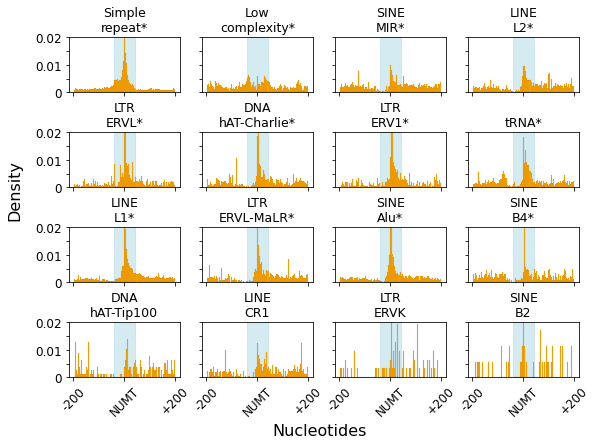

In [23]:
#read in repeats
repeats=pd.read_csv('../../data/repeats.csv')

#create column for numt lengths
repeats['numt_lengths']=repeats['query_name'].apply(lambda query_name: int(query_name.split('_')[-3]))

#get the 40 downstream nucleotides of a given numt plus the 5kb flanking
repeats['downstream_pos']=repeats.apply(lambda row: (5000+(row['numt_lengths']-40)),axis=1)

#filter downstream repeats - it is different for every numt because of the size variability
downstream_repeats=repeats[repeats['piq_begin']>repeats['downstream_pos']]
downstream_repeats['dpiq_begin']=downstream_repeats['piq_begin']-downstream_repeats['numt_lengths']

#function for plotting
def plot_repeats(repeat_class,bins,minval,maxval):
    global row_tracker; global column_tracker
    subdf=repeats.loc[repeats['repeat_class']==repeat_class.replace('*','')]
    subdf=subdf[subdf['piq_begin']<5040]
    upstream_repeats=subdf['piq_begin']
    downstream=downstream_repeats.loc[downstream_repeats['repeat_class']==repeat_class.replace('*','')]['dpiq_begin']
    full_rep=pd.concat([upstream_repeats,downstream])
    full_rep=full_rep[(full_rep>minval)&(full_rep<maxval)]
    kwargs={'edgecolor':'black','lw':0.05}
    ax[row_tracker,column_tracker].hist(full_rep,bins=bins,density=True,stacked=True,color='orange',**kwargs)
    ax[row_tracker,column_tracker].fill_between([4960,5040],ax[row_tracker,column_tracker].get_ylim()[0],ax[row_tracker,column_tracker].get_ylim()[1],alpha=.5,color='lightblue')
    ax[row_tracker,column_tracker].set_ylim(0,0.02)
    if '_' in repeat_class:
        ax[row_tracker,column_tracker].set_title(repeat_class.replace('_',"""\n"""),fontsize=12.5)
    elif '/' in repeat_class:
        ax[row_tracker,column_tracker].set_title(repeat_class.replace('/',"""\n"""),fontsize=12.5)
    else:
        ax[row_tracker,column_tracker].set_title(repeat_class,fontsize=12.5)
    ax[row_tracker,column_tracker].set_xticks([minval,5000,maxval])
    ax[row_tracker,column_tracker].set_xticklabels(['-'+str(5000-minval),'NUMT','+'+str(maxval-5000)],rotation=45,fontsize=12)
    ax[row_tracker,column_tracker].set_yticks([0,0.005,0.01,0.015,0.02])
    ax[row_tracker,column_tracker].set_yticklabels([0,'',0.01,'',0.02],fontsize=12)
    column_tracker+=1
    if column_tracker==4:
        column_tracker+=(-column_tracker)
        row_tracker+=1

#the strange repeats
sig_repeats=pd.Series(['Simple_repeat*','Low_complexity*', 'SINE/MIR*','LINE/L2*',
                       'LTR/ERVL*', 'DNA/hAT-Charlie*', 'LTR/ERV1*','tRNA*',
                       'LINE/L1*','LTR/ERVL-MaLR*','SINE/Alu*','SINE/B4*',
                      'DNA/hAT-Tip100','LINE/CR1','LTR/ERVK','SINE/B2'])

#visualize results and save the figure
row_tracker=0
column_tracker=0
fig,ax=plt.subplots(4,4,figsize=(8,6),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1,
                    hspace=0.4)
sig_repeats.apply(plot_repeats,args=(100,4800,5200,))
plt.tight_layout(pad=1, w_pad=0.0001, h_pad=.1)
plt.text(-.55,-.55,'Density',fontsize=16,transform=ax[1,0].transAxes,rotation=90)
plt.text(1.825,-4.50,'Nucleotides',fontsize=16,transform=ax[1,0].transAxes)
plt.savefig('../../results/rm_densities.png',bbox_inches='tight',dpi=400)